In [74]:
import numpy as np
import plotly.express as ex
import pandas as pd

from numpy import exp

# Singer Acceleration Model

Singer target maneuver model takes the target states to be position, velocity, and acceleration and assumes the target acceleration to be a first-order Markov process of the form:

$$
  a(k+1) = \rho_m a(k) + \sqrt{1 - \rho_m^2} \sigma_m r(k)
$$

where $\rho_m = e^{-\beta T}$, $\beta = 1/\tau_m$, $\tau_m, \sigma_m$ are target maneuver time constant and standard deviation and $r(k)$ is zero-mean, unit-standard deviation Gaussian distributed random variable. This can be collapsed to:

$$
  a(k+1) = e^{-\frac{T}{\tau_m}} a(k) + \sqrt{1 - e^{-\frac{T}{\tau_m}}} \sigma_m r(k)
$$

In [65]:
def acceleration(tau, sigma, T, n=100, rnd=None):
    normal = np.random.normal if rnd is None else rnd.normal
    rho = np.exp(-T / tau)
    res = []
    
    a_k = 0
    for i in range(n):
        a_k_1 = rho * a_k + np.sqrt(1 - rho*rho) * normal(0, sigma)
        res.append(a_k_1)
        a_k = a_k_1

    return np.array(res)

def calculate_dimension(time, a):
    v_last = 0; v = []
    p_last = 0; p = []

    time = [0] + np.diff(time).tolist()
    
    for dt, a_last in zip(time, a):
        p_last += v_last * dt + a_last*dt*dt/2
        v_last += dt*a_last
        p.append(p_last)
        v.append(v_last)
    
    return np.array((np.array(p), np.array(v), a)).T

def sample_singer(tau: float, sigma: float, T: float, n=100, seed=None):
    rnd = np.random.default_rng(seed=seed)
    time = np.arange(n) * T

    # generate position, velocity and acceleration independently in each dimension
    dims = [calculate_dimension(time, acceleration(tau, sigma, T, n, rnd)) for i in range(3)]

    # reshuffle to keep positions, velocities, and accelerations grouped
    ret = [dims[0][:,0], dims[1][:,0], dims[2][:,0],
           dims[0][:,1], dims[1][:,1], dims[2][:,1],
           dims[0][:,2], dims[1][:,2], dims[2][:,2]]
    
    return np.array(ret).T

# Sample traces

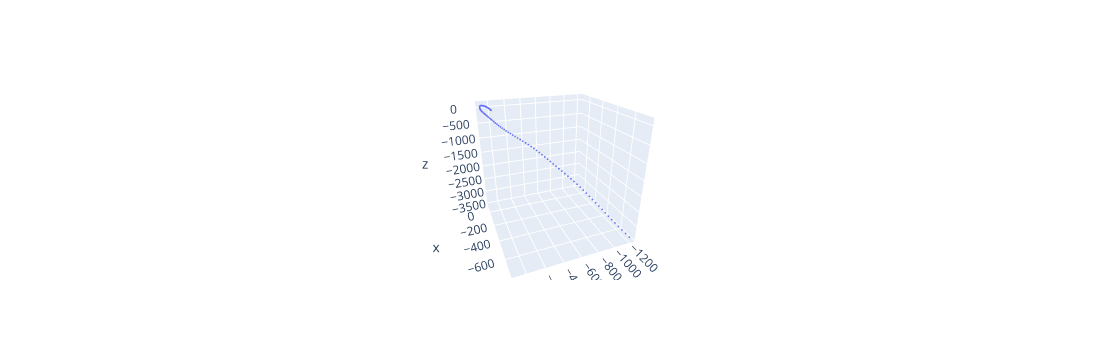

In [68]:
states = sample_singer(10, 1, 1, seed=1)

fig = ex.scatter_3d(x=states[:,0], y=states[:,1], z=states[:,2])
fig.update_traces(marker_size = 1)
fig

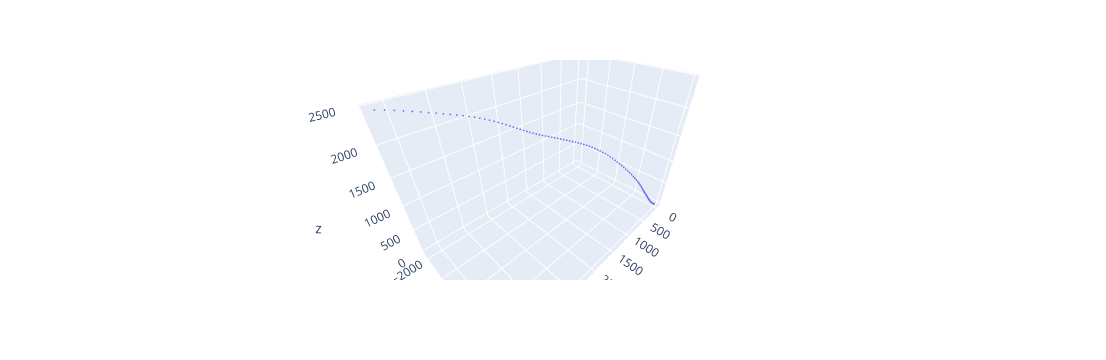

In [72]:
states = sample_singer(10, 1, 1)

fig = ex.scatter_3d(x=states[:,0], y=states[:,1], z=states[:,2])
fig.update_traces(marker_size = 1)
fig

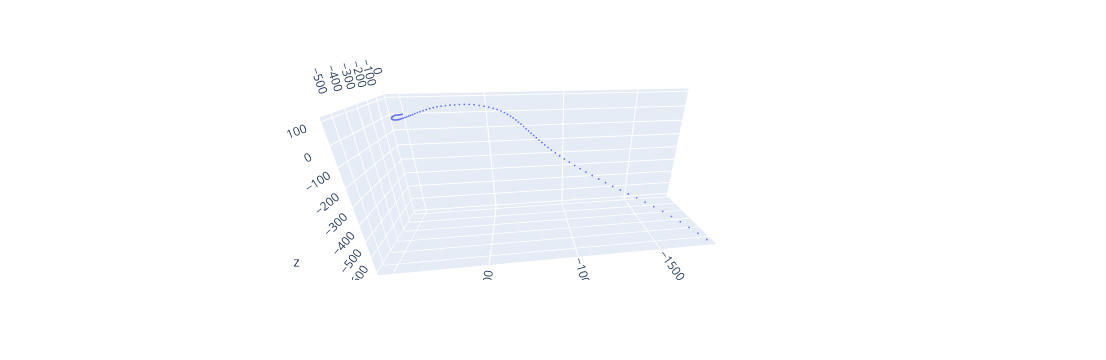

In [73]:
states = sample_singer(10, 1, 1)

fig = ex.scatter_3d(x=states[:,0], y=states[:,1], z=states[:,2])
fig.update_traces(marker_size = 1)
fig

# Kalman Filter

In [ ]:
class SingerAccelerationModel:
    def __init__(self, tau, sigma):
        self.tau = tau
        self.sigma = sigma
        
    def F(self, dt):
        beta = 1/self.tau
        BT   = beta * dt
        rho  = exp(-BT)

        f_1 = 1/beta**2 * (-1 + BT + rho)
        f_2 = 1/beta * (1 - rho)
        f_3 = rho

        return np.array([[1, 0, 0, dt, 0, 0, f_1, 0, 0],
                         [0, 1, 0, 0, dt, 0, 0, f_1, 0],
                         [0, 0, 1, 0, 0, dt, 0, 0, f_1],
                         [0, 0, 0, 1, 0, 0, f_2, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, f_2, 0],
                         [0, 0, 0, 0, 0, 1, 0, 0, f_2],
                         [0, 0, 0, 0, 0, 0, f_3, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, f_3, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, f_3]])
        
    def Q(self, dt):
        beta = 1/self.tau
        BT   = beta * dt
        rho  = exp(-BT)

        e_BT  = exp(-BT)
        e_2BT = exp(-2*BT)
        BT2   = BT**2
        BT3   = BT**3

        q_11 = .5/beta**5 * (1 - e_2BT + 2*BT + 2/3 * BT3 - 2*BT2 - 4*BT*e_BT)
        q_12 = .5/beta**4 * (e_2BT + 1 - 2*e_BT + 2*BT*e_BT - 2*BT + BT2)
        q_13 = .5/beta**3 * (1 - e_2BT - 2*BT*e_BT)
        q_22 = .5/beta**3 * (4*e_BT - 3 - e_2BT + 2*BT)
        q_23 = .5/beta**2 * (e_2BT + 1 - 2*e_BT)
        q_33 = .5/beta * (1 - e_2BT)

        q_21 = q_12
        q_31 = q_13
        q_32 = q_23

        return np.array([[q_11, 0, 0, q_12, 0, 0, q_13, 0, 0],
                         [0, q_11, 0, 0, q_12, 0, 0, q_13, 0],
                         [0, 0, q_11, 0, 0, q_12, 0, 0, q_13],
                         [q_21, 0, 0, q_22, 0, 0, q_23, 0, 0],
                         [0, q_21, 0, 0, q_22, 0, 0, q_23, 0],
                         [0, 0, q_21, 0, 0, q_22, 0, 0, q_23],
                         [q_31, 0, 0, q_32, 0, 0, q_33, 0, 0],
                         [0, q_31, 0, 0, q_32, 0, 0, q_33, 0],
                         [0, 0, q_31, 0, 0, q_32, 0, 0, q_33]])
        

class KalmanFilter:
    def __init__(self, x=np.zeros(9), P=np.eye(9), R=np.eye(3)):
        self.dim = 3                                                  # number of spatial dimensions
        self.R = np.array(R); self.R.shape = (self.dim, self.dim)     # measurement noise
        self.x = np.array(x); self.x.shape = (self.dim*2)             # state (mean)
        self.P = np.array(P); self.P.shape = (self.dim*2, self.dim*2) # state (covariance)
        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],               # measurement matrix
                           [0, 1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0, 0]])
        self.motion_model = SingerAccelerationModel()

    def initialize(self, x, P):
        self.x[:len(x)] = x
        r, c = P.shape
        self.P[:r,:c] = P
    
    # extrapolate state and uncertainty
    def predict(self, dt):
        F = self.motion_model.F(dt)
        Q = self.motion_model.Q(dt)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q

    # update state with a measurement
    def update(self, z):
        z = np.array(z); z.shape = self.dim # measurement

        # Kalman gain
        # K = P*H (H*P*H + R)
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)

        # filtered state (mean)
        # X = X + K(z - H*X)
        self.x = self.x + K @ (z - self.H @ self.x)

        I = np.eye(9)
        
        # filtered state (covariance)
        # P = (I - K*H) * P * (I - K*H) + K*R*K
        self.P = (I - K@self.H) @ self.P @ (I - K@self.H).T + K @ self.R @ K.T

# Evaluation

In [85]:
def cartesian_measurements(positions, noise_covariance):
    noise_mean = np.full(positions.shape[1], 0)
    noise = np.random.multivariate_normal(noise_mean, noise_covariance, size=positions.shape[0])
    return positions + noise

In [105]:
def evaluate(target, kf, time=np.arange(0, 100), z_sigma=.1):
    # calculate target positions over time
    time = np.array(time)
    positions = target.positions(time)
    
    # transform positions into measurements
    z_var = z_sigma*z_sigma
    meas = cartesian_measurements(positions, np.diag([z_var, z_var, z_var]))
    
    # initialize track state
    mean = np.full(6, 0)
    mean[:3] = meas[0,:]
    cov = np.diag(np.full(6, z_var))
    
    kf.initialize(mean, cov)

    # iterate
    err = []
    pos = []
    vel = []
    
    for dt, z in zip(np.diff(time), meas):
        kf.predict(dt)
        pos.append(kf.x[:3])
        vel.append(kf.x[3:6])
        err.append(kf.x[:3] - z)
        kf.update(z)
    
    return positions, np.array(pos), np.array(vel), np.array(err)

In [91]:
def to_df(np_array, col_prefix='x'):
    d = {}
    for i, column in enumerate(np.array(np_array).T):
        d[col_prefix + str(i)] = column
    return pd.DataFrame(d)

# Sinus target

In [125]:
class SinusTarget:
    def __init__(self, speed=20, range=10):
        self.speed = speed
        self.range = range

    def positions(self, t):
        t = np.array(t)
        x = np.sin(t / 180 * np.pi * self.speed) * self.range
        y = np.full_like(t, 0)
        z = np.arange(0, len(t))
        return np.array((x, y, z)).T

In [126]:
target, pos, vel, err  = evaluate(SinusTarget(), KalmanFilter(), time=np.arange(0, 400))

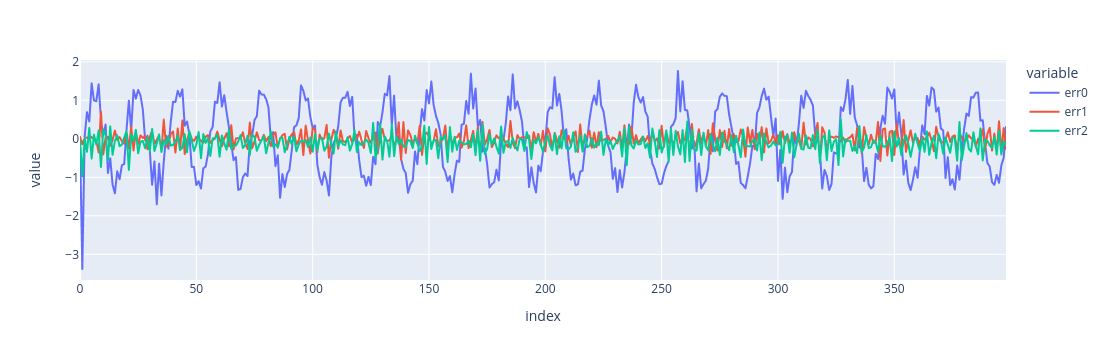

In [127]:
ex.line(to_df(err, 'err'))

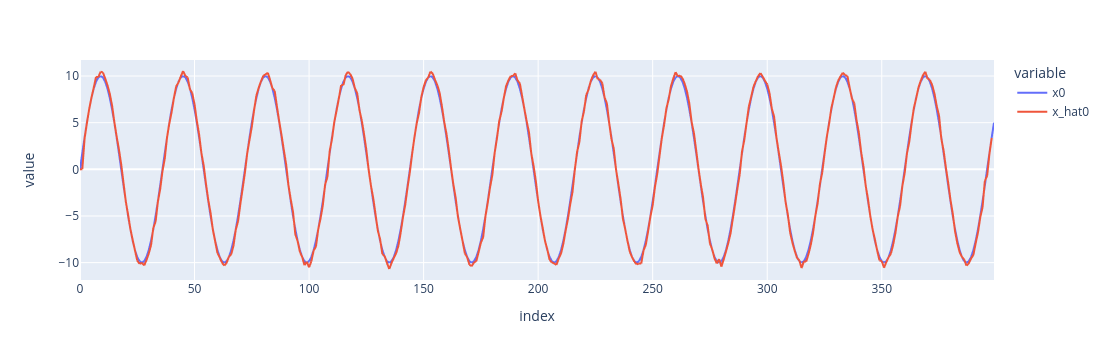

In [124]:
ex.line(pd.concat((to_df(target, 'x'), to_df(pos, 'x_hat')))[['x0', 'x_hat0']])

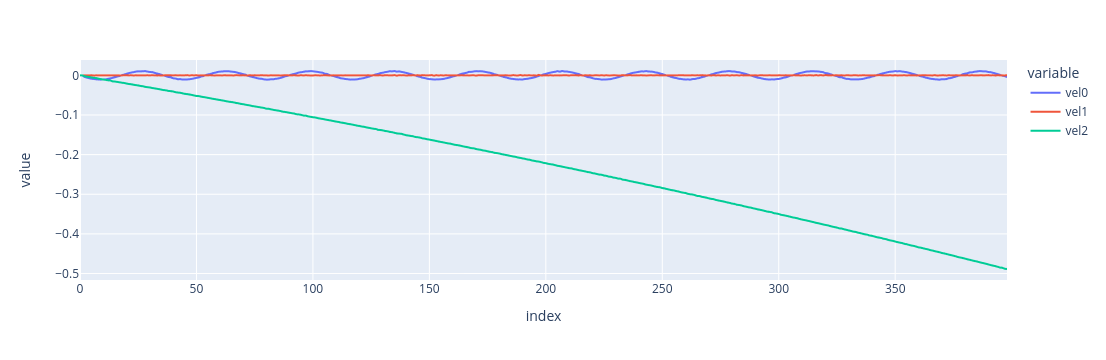

In [114]:
ex.line(to_df(vel, 'vel'))